### 1) 모델 세팅, 데이터 세팅, 함수 세팅

In [1]:
import re
import ntpath 
from data_model.BuildModel import BuildModel
from data_model.ModelType import ModelType
import torch
import torchvision.models as M

RANGES = [
    ((1, 50),   "Happiness"),
    ((51, 100), "Surprise"),
    ((101,150), "Neutral"),
    ((151,200), "Fear"),
    ((201,250), "Disgust"),
    ((251,300), "Anger"),
    ((301,350), "Sadness"),
]
CLASSES = list(map(lambda x: x[1], RANGES))
label2idx = {name:i  for i,name in enumerate(CLASSES)}

device = "cuda:0" if torch.cuda.is_available() else "cpu"
buildModel = BuildModel(ModelType.CONVNEXT_SMALL, len(RANGES), M.ConvNeXt_Small_Weights.IMAGENET1K_V1)
model = buildModel.model
model.to(device)

def score_to_label(score:int):
    for (low,high), label in RANGES:
        if low <= score <= high: 
            return label

def parse_label_from_name(path:str):
    stem = ntpath.splitext(ntpath.basename(path))[0]
    m = re.match(r'^\d+-(\d+)_mel$',stem)
    return int(m.group(1))

def parse_label_idx(path: str) -> int:
    score = parse_label_from_name(path)
    name  = score_to_label(score)
    return label2idx[name]

c:\PythonProject\aug-08month_project5\.venv\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


### 2) 이미지 전처리

In [2]:
from torchvision import transforms as T
import os
from data_model.GlobalVariable import ImageVariable
from pre_process.img_preprocess import TrimBorder,compute_mean_std, TimeMask, FreqMask
from pathlib import Path

if os.name == "posix":  # Linux, macOS
    ROOT = "/home/wanted-1/PotenupWorkspace/aug-project5/jin_sup/mel_image"
elif os.name == "nt":   # Windows
    ROOT = "C:\\PythonProject\\aug-08month_project5\\jin_sup\\mel_image"

all_full_paths = sorted([str(p) for p in Path(ROOT).rglob("*.png")])

mean, std = compute_mean_std(all_full_paths)
print(f"평균 : {mean}")
print(f"표준편차 : {std}")

norm = T.Normalize(mean=[mean, mean, mean], std=[std, std, std])

# 멜스펙 1채널 -> 3채널
train_tf = T.Compose([
    TrimBorder(10),
    T.Grayscale(3),  
    
    T.Resize(ImageVariable.IMAGE_SIZES, antialias=True),
    T.CenterCrop(ImageVariable.IMAGE_SIZES),
    TimeMask(max_width=0.12, p=0.6, value=0.0),
    FreqMask(max_height=0.15, p=0.6, value=0.0),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0.02,0.02))], p=0.3),
    T.ToTensor(),
    T.RandomErasing(p=0.25, scale=(0.02,0.08), ratio=(0.3,3.3), value=0.0),
    norm
])

test_tf = T.Compose([
    TrimBorder(10),
    T.Grayscale(3),
    T.Resize(ImageVariable.IMAGE_SIZES, antialias=True),
    T.CenterCrop(ImageVariable.IMAGE_SIZES),
    T.ToTensor(),
    norm,
])

평균 : 0.6226921126314113
표준편차 : 0.3423165454990286


### 3) 학습, 검증 데이터 분류

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

y_all = list(map(parse_label_idx, all_full_paths))
X_train, X_test, y_train, y_test = train_test_split(
    all_full_paths, y_all, test_size=0.2, stratify=y_all, random_state=42
)

### 4) 배치 및 전처리 적용

In [4]:
from PIL import Image
class MelSpecImageDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = list(paths)
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        y = parse_label_idx(p)
        img = Image.open(p).convert("RGB")
        x = self.transform(img)
        return x, y

In [5]:
X_train_ds = MelSpecImageDataset(X_train, train_tf)
X_test_ds = MelSpecImageDataset(X_test, test_tf)

BATCH_SIZE = 32
NUM_WORKERS = 0
X_train_dl = DataLoader(
    X_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

X_test_dl = DataLoader(
    X_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

## 4-1) 전처리된 이미지 확인

c:\PythonProject\aug-08month_project5\.venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


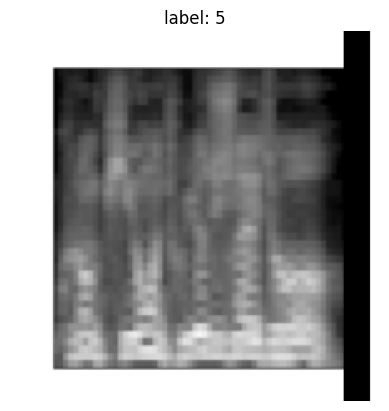

In [6]:
import random 
import matplotlib.pyplot as plt

def denorm(t):
    mean = torch.tensor(ImageVariable.MEAN).view(-1,1,1)
    std  = torch.tensor(ImageVariable.STD).view(-1,1,1)
    return t * std + mean

# DataLoader에서 배치 하나 뽑기
batch = next(iter(X_train_dl))   # (x, label) 반환한다고 가정
images, labels = batch

# 배치에서 랜덤 인덱스 뽑기
idx = random.randint(0, images.size(0)-1)
img = images[idx]   # [C,H,W]
label = labels[idx]

# denorm 후 디스플레이
img_denorm = denorm(img.clone())

if img_denorm.shape[0] == 1:
    plt.imshow(img_denorm.squeeze(0).cpu().numpy(), cmap="gray")
else:
    plt.imshow(img_denorm.permute(1,2,0).cpu().numpy())
    
plt.title(f"label: {label.item()}")
plt.axis("off")
plt.show()

### 5) 모델 학습 및 텐서 보드

In [7]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

# 이미지 크기 사이즈가 고정일 경우 캐시 연산을 위하여 사용 
torch.backends.cudnn.benchmark = True

# 처음 값
# lr = 1e-4
# weight_decay=1e-4
lr =  3e-4
criterion = nn.CrossEntropyLoss()
optimz = optim.AdamW(model.parameters(), lr= lr, weight_decay=1e-5)
steps_per_epoch = len(X_train_dl)
EPOCHS = 20
total_steps = EPOCHS * steps_per_epoch
warmup_steps = max(100, int(0.05 * total_steps))   # 

sched_warmup = LinearLR(optimz, start_factor=0.01, total_iters=warmup_steps)  # 1% -> 100%
T_max = max(1, total_steps - warmup_steps)  # 방어
sched_cosine = CosineAnnealingLR(optimz, T_max=T_max, eta_min=lr * 0.01)
scheduler = SequentialLR(optimz, [sched_warmup, sched_cosine], milestones=[warmup_steps])

# EarlyStopping
# patience, min_delta = 5, 1e-3
# best_val, bad_epochs = float("inf"), 0


import torch
print(torch.cuda.is_available())   # False 라고 나오면 GPU 안잡힘 
print(torch.__version__)           # torch 버전 확인 


False
2.8.0+cpu


In [8]:
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm
# from datetime import datetime


# writer = SummaryWriter(log_dir="runs/convnext_experiment1")


# step = 0
# for epoch in range(1, EPOCHS + 1):
#     model.train()
    
#     for train, label in tqdm(X_train_dl):
#         try: 
#             optimz.zero_grad()
#             train, label = train.to(device), label.to(device)
            
#             logits = model(train)             
#             loss = criterion(logits, label)   

#             loss.backward()
#             optimz.step()  
#             scheduler.step()
#             #텐서 보드 기록
#             writer.add_scalar("Loss/train", loss.item(), step)
#             step += 1
            
#         except Exception as e:
#             print(f"❌ Error in training loop (epoch={epoch}): {e}")
#             raise  


# timestamp = datetime.now().strftime("%m-%d_%H-%M-%S")
# filename = f"result_{timestamp}"
# torch.save(model.state_dict(), f"model/model_{buildModel.weights}___{timestamp}.pth")



### 6) 모델 평가 및 저장

In [12]:
from sklearn.metrics import classification_report, f1_score
from datetime import datetime
import os, shutil
import torch
from data_model.BuildModel import BuildModel
from data_model.ModelType import ModelType
import torchvision.models as M
import torch
from util_tool import resolve_path

device = "cuda:0" if torch.cuda.is_available() else "cpu"
if os.name == "posix":  # Linux, macOS
    path = "/home/wanted-1/PotenupWorkspace/aug-project5/jin_sup/model/model_ConvNeXt_Small_Weights.IMAGENET1K_V1___08-25_16-16-16.pth"
elif os.name == "nt":  # Windows
    path = "C:\\PythonProject\\aug-08month_project5\\jin_sup\\model\\model_ConvNeXt_Small_Weights.IMAGENET1K_V1___08-25_16-16-16.pth"


checkpoint = torch.load(path, map_location="cpu")

y_true, y_pred = [], []
model = BuildModel.get_model(ModelType.CONVNEXT_SMALL,
                             M.ConvNeXt_Small_Weights.IMAGENET1K_V1,
                               7 , checkpoint, device)


# 오분류 저장셋
mis_list = []  
save_root = Path("./misclassified")  
save_root.mkdir(parents=True, exist_ok=True)
running_idx = 0

model.eval()
with torch.no_grad():
    for train, label in X_test_dl:
        train, label = train.to(device), label.to(device)

        logits = model(train)
        pred = logits.argmax(dim=1)

        y_true.extend(label.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())

        mism = (pred != label)
        if mism.any():
            mism_indices = torch.where(mism)[0].tolist()
            for i in mism_indices:
                ds_idx = running_idx + i  # DataLoader 내 전체 인덱스(셔플 없을 때)
                path = resolve_path(X_test_dl.dataset, ds_idx)
                t = int(label[i].item())
                p = int(pred[i].item())
                t_name = CLASSES[t] if 'CLASSES' in globals() and 0 <= t < len(CLASSES) else str(t)
                p_name = CLASSES[p] if 'CLASSES' in globals() and 0 <= p < len(CLASSES) else str(p)

                mis_list.append((ds_idx, path, t, p, t_name, p_name))

                # 원본 파일이 있으면 복사 (라벨/예측별 폴더로 정리)
                if path is not None and os.path.exists(path):
                    out_dir = save_root / f"true_{t_name}__pred_{p_name}"
                    out_dir.mkdir(parents=True, exist_ok=True)
                    shutil.copy2(path, out_dir / Path(path).name)

        running_idx += label.size(0)        



f1_macro = f1_score(y_true, y_pred, average="macro")  # 클래스별 f1을 평균
f1_micro = f1_score(y_true, y_pred, average="micro")  # 전체 샘플 기준 평균
f1_weighted = f1_score(y_true, y_pred, average="weighted")  # 클래스 비율 고려

print("F1(macro):", f1_macro)
print("F1(micro):", f1_micro)
print("F1(weighted):", f1_weighted)

print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

F1(macro): 0.8665073979424822
F1(micro): 0.8662481892805408
F1(weighted): 0.8664679424050074
              precision    recall  f1-score   support

   Happiness     0.8502    0.8161    0.8328       299
    Surprise     0.8721    0.8691    0.8706       298
     Neutral     0.9412    0.9189    0.9299       296
        Fear     0.8257    0.8508    0.8381       295
     Disgust     0.8147    0.8644    0.8388       295
       Anger     0.8947    0.8673    0.8808       294
     Sadness     0.8716    0.8776    0.8746       294

    accuracy                         0.8662      2071
   macro avg     0.8672    0.8663    0.8665      2071
weighted avg     0.8672    0.8662    0.8665      2071



## 7) Grad Cam 확인

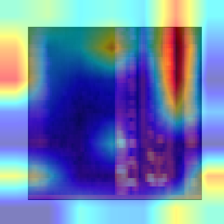

In [ ]:
from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np

# 1) PIL 로드 + 확실히 224로 재할당
pil = Image.open("../jin_sup/mel_image/099-335_mel.png").convert("RGB")
pil = pil.resize((224, 224))                  # ← 재할당 필수!

# 2) 시각화용 이미지(0~1, HWC)
rgb_img = np.float32(pil) / 255.0

# 3) 모델 입력 텐서(1,3,224,224) - buildModel.preprocess 안에 Resize가 있으면 제거 권장
test_tf = T.Compose([
    TrimBorder(10),
    T.Grayscale(3),
    T.Resize(ImageVariable.IMAGE_SIZES, antialias=True),
    T.CenterCrop(ImageVariable.IMAGE_SIZES),
    T.ToTensor(),
    norm,
])
tf = T.Compose([T.ToTensor(), buildModel.preprocess])
input_tensor = tf(pil).unsqueeze(0).to(device)

# 4) CAM
target_layers = [model.features[-1][-1].block]
targets = [ClassifierOutputTarget(1)]
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]   

result = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
display(Image.fromarray(result))